# Lab:  PCA, LDA and Logistic Regression for Gene Expression Data

In this lab, we use logistic regression to predict biological characteristics ("phenotypes") from gene expression data.  In addition to the concepts in breast cancer demo, you will learn to:

* Handle missing data
* Compute and visualize PCA and LDA coefficients
* Combine PCA and LDA with scaling
* Perform multi-class logistic classification on PCA and LDA outputs.
* Evaluate multi-class logistic classification with K-fold validation

## Background

Genes are the basic unit in the DNA and encode blueprints for proteins.  When proteins are synthesized from a gene, the gene is said to "express".  Micro-arrays are devices that measure the expression levels of large numbers of genes in parallel.  By finding correlations between expression levels and phenotypes, scientists can identify possible genetic markers for biological characteristics.

The data in this lab comes from:

https://archive.ics.uci.edu/ml/datasets/Mice+Protein+Expression

In this data, mice were characterized by three properties:

* Whether they had down's syndrome (trisomy) or not
* Whether they were stimulated to learn or not
* Whether they had a drug memantine or a saline control solution.

With these three choices, there are 8 possible classes for each mouse.  For each mouse, the expression levels were measured across 77 genes.  We will see if the characteristics can be predicted from the gene expression levels.  This classification could reveal which genes are potentially involved in Down's syndrome and if drugs and learning have any noticeable effects.


## Load the Data

We begin by loading the standard packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
%matplotlib inline
from sklearn import linear_model, preprocessing

Use the `pd.read_excel` command to read the data from 

https://archive.ics.uci.edu/ml/machine-learning-databases/00342/Data_Cortex_Nuclear.xls

into a dataframe `df`.  Use the `index_col` option to specify that column 0 is the index.  Use the `df.head()` to print the first few rows.

In [2]:
# TODO
df = pd.read_excel('Data_Cortex_Nuclear.xls',index_col=0) 
df.head(10)

,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,Control,Memantine,C/S,c-CS-m
309_7,0.428033,0.573696,0.342709,2.334224,4.473130,0.225173,0.184004,2.012414,0.195789,1.612036,...,0.111483,0.406293,0.137229,0.156682,0.157499,1.528484,Control,Memantine,C/S,c-CS-m
309_8,0.416923,0.564036,0.327703,2.260135,4.268735,0.214834,0.179668,2.007985,0.189803,1.424601,...,0.113080,0.382532,0.123376,0.155612,0.159409,1.652658,Control,Memantine,C/S,c-CS-m
309_9,0.386311,0.538428,0.317720,2.125725,4.063950,0.207222,0.167778,1.861514,0.180684,1.261891,...,0.105490,0.435687,0.125173,0.152711,0.158235,1.834599,Control,Memantine,C/S,c-CS-m


This data has missing values.  The site:

http://pandas.pydata.org/pandas-docs/stable/missing_data.html

has an excellent summary of methods to deal with missing values.  Following the techniques there, create a new data frame `df1` where the missing values in each column are filled with the mean values from the non-missing values.

In [3]:
# TODO
df1 = df.copy(deep=True)
row_length = len(df1.iloc[:,0])
col_length = df1.columns.tolist() 
print('Number of Observations : ', len(df1.iloc[:,0]))
print('Number of Predictor variables : ',len(col_length))

means = df1.mean(0) # means of each column
for column in range(0,len(col_length)):
    for row in range(0,row_length):
        if pd.isnull(df1.iloc[row, column]) == True: 
            df1.iloc[row,column] = means[column]
df1.head(10)

Number of Observations :  1080
Number of Predictor variables :  81


,DYRK1A_N,ITSN1_N,BDNF_N,NR1_N,NR2A_N,pAKT_N,pBRAF_N,pCAMKII_N,pCREB_N,pELK_N,...,pCFOS_N,SYP_N,H3AcK18_N,EGR1_N,H3MeK4_N,CaNA_N,Genotype,Treatment,Behavior,class
MouseID,,,,,,,,,,,,,,,,,,,,,
309_1,0.503644,0.747193,0.430175,2.816329,5.990152,0.218830,0.177565,2.373744,0.232224,1.750936,...,0.108336,0.427099,0.114783,0.131790,0.128186,1.675652,Control,Memantine,C/S,c-CS-m
309_2,0.514617,0.689064,0.411770,2.789514,5.685038,0.211636,0.172817,2.292150,0.226972,1.596377,...,0.104315,0.441581,0.111974,0.135103,0.131119,1.743610,Control,Memantine,C/S,c-CS-m
309_3,0.509183,0.730247,0.418309,2.687201,5.622059,0.209011,0.175722,2.283337,0.230247,1.561316,...,0.106219,0.435777,0.111883,0.133362,0.127431,1.926427,Control,Memantine,C/S,c-CS-m
309_4,0.442107,0.617076,0.358626,2.466947,4.979503,0.222886,0.176463,2.152301,0.207004,1.595086,...,0.111262,0.391691,0.130405,0.147444,0.146901,1.700563,Control,Memantine,C/S,c-CS-m
309_5,0.434940,0.617430,0.358802,2.365785,4.718679,0.213106,0.173627,2.134014,0.192158,1.504230,...,0.110694,0.434154,0.118481,0.140314,0.148380,1.839730,Control,Memantine,C/S,c-CS-m
309_6,0.447506,0.628176,0.367388,2.385939,4.807635,0.218578,0.176233,2.141282,0.195188,1.442398,...,0.109446,0.439833,0.116657,0.140766,0.142180,1.816389,Control,Memantine,C/S,c-CS-m
309_7,0.428033,0.573696,0.342709,2.334224,4.473130,0.225173,0.184004,2.012414,0.195789,1.612036,...,0.111483,0.406293,0.137229,0.156682,0.157499,1.528484,Control,Memantine,C/S,c-CS-m
309_8,0.416923,0.564036,0.327703,2.260135,4.268735,0.214834,0.179668,2.007985,0.189803,1.424601,...,0.113080,0.382532,0.123376,0.155612,0.159409,1.652658,Control,Memantine,C/S,c-CS-m
309_9,0.386311,0.538428,0.317720,2.125725,4.063950,0.207222,0.167778,1.861514,0.180684,1.261891,...,0.105490,0.435687,0.125173,0.152711,0.158235,1.834599,Control,Memantine,C/S,c-CS-m


We next get the data as `numpy` arrays.  For the predictors, `X`, we will the expression levels of the `ngene=77` genes.  The expression levels are stored in the first 77 columns of the dataframe `df1`.

* Set `xnames` = the names of genes (you can get them from `df1.columns`)
* Set `X` = a `numpy` array with the values of the expression levels.  (you can get this from `df1[xnames].values`)

In [4]:
# TODO
ngene = 77
xnames = df1.columns[:ngene]
X = np.array( df1[xnames].values )

Now run the following code which will extract the `class` of each measurement into a vector `y`.  The values `y` will have values 0 to 7 corresponding to the 8 classes.  Our goal will be to predict `y` from `X`.

In [5]:
ystr = df1['class'].values
vals, y = np.unique(ystr, return_inverse=True)

Next, split the data into training and test.  You can use the `train_test_split` function.  Set `shuffle=True` and `test_size=0.5`.

In [6]:
from sklearn.model_selection import train_test_split

# TODO
np.random.seed(0)
Xtr, Xts, ytr, yts = train_test_split(X, y, test_size=0.5, shuffle=True)

## PCA on the Data

We will first try to perform PCA.  With PCA, it is import to first scale the data matrix to remove the mean and normalize the features by their variance.  We can do the scaling and PCA in two steps using routines from `sklearn` package:

* Create a scaling object, `scaler = StandardScaler(...)` and `fit` and `transform` the scaler on the training data, `Xtr`.
* Create a PCA object, `pca = PCA(...)` and `fit` the PCA coefficients on the scaled data.  In order that we can visualize the results, set `n_components=2`.


In [7]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

# TODO:  Fitting the scaler
scaler = StandardScaler()
scaled_Xtr = scaler.fit_transform(Xtr)

pca = PCA(n_components = 2)
pc = pca.fit_transform(scaled_Xtr)
pca_tr = pd.DataFrame(data = pc, columns = 
                    ['principal component 1', 'principal component 2'])

pca_tr.head(7)

,principal component 1,principal component 2
0,8.547824,-2.404200
1,-1.115861,-1.925297
2,-0.187681,0.823154
3,6.927715,-1.039894
4,1.795093,-1.732607
5,-9.581575,-1.538212
6,-8.270530,-1.589007


Now use the `transform` method to transform the test data `Xts` through the `scaler` and `pca` objects.  Create a scatter plot using the `plt.scatter` function of the points from the two classes.  Use different colors for each class.  You will see that the PCA representation does not differentiate the classes well along the two components

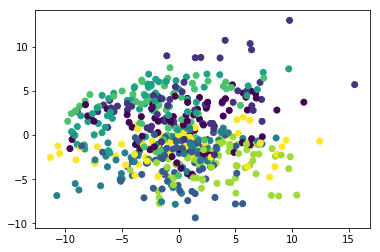

In [8]:
# TODO
plt.scatter(pca_tr['principal component 1'] , 
            pca_tr['principal component 2'], c = ytr)

## LDA on the Data

A better way to transform data in a way that separates classes is LDA.  The `sklearn` has excellent routines for LDA.

* As in the PCA case, create a scaling object, `scaler = StandardScaler(...)` and `fit` and `transform` the scaler on the training data, `Xtr`.
* Next create an LDA object, `lda = LinearDiscriminantAnalysis(...)`.  To avoid ill-conditioning, set `shrinkage='auto'` and `solver='eigen'`.  Fit the LDA transform from the scaled output of `scaler`.


In [9]:
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis

# TODO
scaler = StandardScaler()
scaled_Xtr = scaler.fit_transform(Xtr)
lda = LinearDiscriminantAnalysis(n_components = 2, shrinkage='auto', solver='eigen')
X_lda = lda.fit_transform(scaled_Xtr, ytr)
X_lda

array([[-2.66023746,  0.26346604],
       [-1.94472584, -0.88980944],
       [-1.77930842, -0.70357218],
       ...,
       [-2.42579148,  0.52302433],
       [-1.66490475, -0.80635224],
       [ 1.7453837 , -0.5702511 ]])

Now transform the test data `Xts` through the `scaler` and `lda` objects.  Create a scatter plot using the `plt.scatter` function of the points from the two classes.  Use different colors for each class.  You will see that LDA results in much better separation.

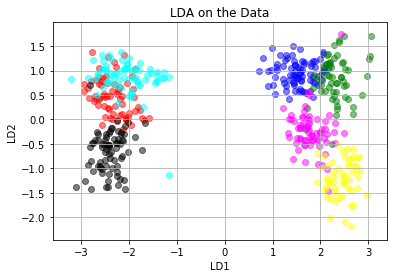

In [10]:
# TODO
def plot_scikit_lda(X, title):
    ax = plt.subplot(111)
    for label, color in zip(range(0,8), ('blue','green','red','cyan',
        'magenta','yellow','black','white') ):
        plt.scatter(x = X[:,0][ytr == label],
                    y = X[:,1][ytr == label] * -1, # flip the figure
                    color=color,
                    alpha=0.5)
    plt.xlabel('LD1')
    plt.ylabel('LD2')
    plt.title(title)
    plt.grid()
    plt.show()

plot_scikit_lda(X_lda, title='LDA on the Data')

## Logisitc Regression on the LDA Data

We will now build a linear classifier from the LDA outputs.  To fit the classifier, we use a three step pipeline:

* As above, create a scaling object, `scaler = StandardScaler(...)` and `fit` and `transform` the scaler on the training data, `Xtr`.  
* Also, as above create an LDA object, `lda = LinearDiscriminantAnalysis(...)` and `fit` and `transform` the scaled training data.  Call the transformed output `Ztr`.
* Create a logistic regression object, `logreg = linear_model.LogisticRegression(...)`.  Set `solver='lbfgs'`, and `multi_class='auto'`.  Fit the model on the transformed training data.

In [11]:
# TODO
scaler = StandardScaler()
scaled_Xtr = scaler.fit_transform(Xtr)

lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
ztr = lda.fit_transform(scaled_Xtr, ytr)

logreg = linear_model.LogisticRegression(solver='lbfgs', multi_class='auto')
logreg.fit(ztr, ytr)

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='auto',
          n_jobs=None, penalty='l2', random_state=None, solver='lbfgs',
          tol=0.0001, verbose=0, warm_start=False)

Now test the model on the test data:
    
* Scale the test data `Xts` with the `scaler.transform()` method
* Transform the scaled test data with the `lda.transform()` method
* Predict the class labels from `logreg.predict`.  Call the outputs `yhat`.
* Measure the accuracy by comparing the outputs `yhat` with `yts`.

If you did everything correctly, you should get an accuracy of around 94%.

In [12]:
# TODO
scaled_Xts = scaler.transform(Xts)
zts = lda.transform(scaled_Xts)
y_pred = logreg.predict(zts)

np.mean(y_pred == yts) # Accuracy Rate

0.95

## K-Fold Cross Validation

K-Fold validation can yield better assessments of the accuracy when the training data is limited.  Complete the following code to perform 5 fold validation.

In [37]:
from sklearn.model_selection import KFold
from sklearn.metrics import precision_recall_fscore_support
nfold = 5
kf = KFold(n_splits=nfold,shuffle=True)
acc = np.zeros(nfold)

for i, I in enumerate(kf.split(ztr)):
            
    # Get training and test data
    Itr, Its = I
    Xtr = X[Itr,:]
    ytr = y[Itr]
    Xts = X[Its,:]
    yts = y[Its]
    
    # TODO:  Train the scaler, lda and logistic regression model on the training data
    scaled_Xtr = scaler.fit_transform(Xtr)
    lda = LinearDiscriminantAnalysis(shrinkage='auto', solver='eigen')
    lda_Xtr = lda.fit_transform(scaled_Xtr, ytr)
    logreg.fit(lda_Xtr, ytr) 
    
    # TODO:  Test the scaler, lda and regression model on the test data
    scaled_Xts = scaler.transform(Xts)
    lda_Xts = lda.transform(scaled_Xts)
    y_hat = logreg.predict(lda_Xts)

    
    # TODO:  Measure accuracy and store in acc[i]
    acc[i] = np.mean(y_hat == yts)
    
# TODO :  Print the mean and SE on the accuracy
print('Mean : ', np.mean(acc))
print('Standard Error : ', np.std(acc)/np.sqrt(nfold-1))


Mean :  0.9907407407407408
Standard Error :  0.004140866624999604
